In [1]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc

Using TensorFlow backend.


In [2]:
def build_rand_feat():
	X = []
	y = []
	_min, _max = float('inf'), -float('inf')
	for _ in tqdm(range(n_samples)):
		rand_class = np.random.choice(class_dist.index, p=prob_dist)
		file = np.random.choice(df[df.label==rand_class ].index)
		rate, wav = wavfile.read('clean/'+file)
		label = df.at[file, 'label']
		rand_index = np.random.randint(0, wav.shape[0]-config.step)
		sample = wav[rand_index:rand_index+config.step]
		X_sample = mfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T
		_min = min(np.amin(X_sample), _min)
		_max = max(np.amax(X_sample), _max)
		X.append(X_sample if config.mode=='conv' else X_sample.T)
		y.append(classes.index(label))
	X, y = np.array(X), np.array(y)
	X = (X - _min) / (_max - _min)
    
	if config.mode == 'conv':
		X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
	elif config.mode == 'mode':
		X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
	y = to_categorical(y, num_classes=8)
	return X, y

In [3]:
def get_conv_model():
	model = Sequential()
	model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
	model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same'))
	model.add(MaxPool2D((2, 2)))
	model.add(Dropout(0.5))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dense(64, activation='relu'))
	model.add(Dense(32, activation='relu'))
	model.add(Dense(8, activation='softmax'))
	model.summary()
	model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
	return model

In [4]:
class Config:
	def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=512, rate=16000):
		self.mode = mode
		self.nfilt = nfilt
		self.nfeat = nfeat
		self.nfft = nfft
		self.rate = rate
		self.step = int(rate/10)

In [5]:
df = pd.read_csv('commands.csv')
df.set_index('fname', inplace=True)

In [6]:
for f in df.index:
    rate, signal = wavfile.read('clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

In [7]:
classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

In [8]:
n_samples = 2 * int(df['length'].sum()/0.1)
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

(-1.1017479394565692,
 1.1027035336274034,
 -1.1007501761641811,
 1.100035747505556)

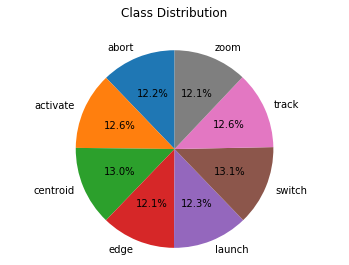

In [9]:
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%', shadow=False, startangle=90)
ax.axis('equal')

In [10]:
config = Config(mode = 'conv')

In [11]:
if config.mode == 'conv':
	X, y = build_rand_feat()
	y_flat = np.argmax(y, axis=1)
	input_shape = (X.shape[1], X.shape[2], 1)
	model = get_conv_model()
elif config.mode == 'time':
	X, y = build_rand_feat()
	y_flat = np.argmax(y, axis=1)
	input_shape = (X.shape[1], X.shape[2])
	model = get_recurrent_model()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20314/20314 [01:12<00:00, 279.93it/s]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 13, 9, 16)         160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 9, 32)         4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 9, 64)         18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 9, 128)        73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 4, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
__________

In [12]:
class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat)

In [ ]:
model.fit(X, y, epochs=10,  batch_size=32, shuffle=True, class_weight=class_weight)

Epoch 1/10


 6880/20314 [=========>....................] - ETA: 44s - loss: 0.0684 - acc: 0.46 - ETA: 44s - loss: 0.0655 - acc: 0.53 - ETA: 42s - loss: 0.0683 - acc: 0.51 - ETA: 42s - loss: 0.0666 - acc: 0.53 - ETA: 41s - loss: 0.0705 - acc: 0.51 - ETA: 40s - loss: 0.0692 - acc: 0.54 - ETA: 40s - loss: 0.0710 - acc: 0.52 - ETA: 40s - loss: 0.0705 - acc: 0.52 - ETA: 39s - loss: 0.0701 - acc: 0.52 - ETA: 39s - loss: 0.0720 - acc: 0.50 - ETA: 39s - loss: 0.0727 - acc: 0.49 - ETA: 39s - loss: 0.0725 - acc: 0.49 - ETA: 39s - loss: 0.0731 - acc: 0.48 - ETA: 39s - loss: 0.0735 - acc: 0.48 - ETA: 39s - loss: 0.0728 - acc: 0.49 - ETA: 38s - loss: 0.0721 - acc: 0.50 - ETA: 38s - loss: 0.0713 - acc: 0.50 - ETA: 38s - loss: 0.0719 - acc: 0.50 - ETA: 38s - loss: 0.0719 - acc: 0.50 - ETA: 38s - loss: 0.0715 - acc: 0.50 - ETA: 38s - loss: 0.0717 - acc: 0.50 - ETA: 38s - loss: 0.0721 - acc: 0.49 - ETA: 38s - loss: 0.0714 - acc: 0.50 - ETA: 38s - loss: 0.0713 - acc: 0.50 - ETA: 38s - loss: 0.0709 - acc: 0.50 - ETA

13760/20314 [===================>..........] - ETA: 26s - loss: 0.0736 - acc: 0.51 - ETA: 26s - loss: 0.0736 - acc: 0.51 - ETA: 26s - loss: 0.0737 - acc: 0.51 - ETA: 26s - loss: 0.0736 - acc: 0.51 - ETA: 26s - loss: 0.0736 - acc: 0.51 - ETA: 26s - loss: 0.0736 - acc: 0.51 - ETA: 26s - loss: 0.0736 - acc: 0.51 - ETA: 26s - loss: 0.0736 - acc: 0.51 - ETA: 26s - loss: 0.0736 - acc: 0.51 - ETA: 25s - loss: 0.0735 - acc: 0.51 - ETA: 25s - loss: 0.0734 - acc: 0.51 - ETA: 25s - loss: 0.0735 - acc: 0.51 - ETA: 25s - loss: 0.0735 - acc: 0.51 - ETA: 25s - loss: 0.0735 - acc: 0.51 - ETA: 25s - loss: 0.0736 - acc: 0.51 - ETA: 25s - loss: 0.0736 - acc: 0.51 - ETA: 25s - loss: 0.0735 - acc: 0.51 - ETA: 25s - loss: 0.0735 - acc: 0.51 - ETA: 25s - loss: 0.0737 - acc: 0.51 - ETA: 25s - loss: 0.0737 - acc: 0.51 - ETA: 25s - loss: 0.0737 - acc: 0.51 - ETA: 25s - loss: 0.0737 - acc: 0.51 - ETA: 25s - loss: 0.0736 - acc: 0.51 - ETA: 24s - loss: 0.0736 - acc: 0.51 - ETA: 24s - loss: 0.0735 - acc: 0.51 - ETA

20314/20314 [==============================] - ETA: 12s - loss: 0.0733 - acc: 0.51 - ETA: 12s - loss: 0.0733 - acc: 0.51 - ETA: 12s - loss: 0.0733 - acc: 0.51 - ETA: 12s - loss: 0.0733 - acc: 0.51 - ETA: 12s - loss: 0.0733 - acc: 0.51 - ETA: 12s - loss: 0.0734 - acc: 0.51 - ETA: 12s - loss: 0.0734 - acc: 0.51 - ETA: 12s - loss: 0.0734 - acc: 0.51 - ETA: 12s - loss: 0.0734 - acc: 0.51 - ETA: 12s - loss: 0.0734 - acc: 0.51 - ETA: 12s - loss: 0.0734 - acc: 0.51 - ETA: 12s - loss: 0.0735 - acc: 0.51 - ETA: 12s - loss: 0.0734 - acc: 0.51 - ETA: 11s - loss: 0.0735 - acc: 0.51 - ETA: 11s - loss: 0.0734 - acc: 0.51 - ETA: 11s - loss: 0.0734 - acc: 0.51 - ETA: 11s - loss: 0.0734 - acc: 0.51 - ETA: 11s - loss: 0.0734 - acc: 0.51 - ETA: 11s - loss: 0.0734 - acc: 0.51 - ETA: 11s - loss: 0.0734 - acc: 0.51 - ETA: 11s - loss: 0.0734 - acc: 0.51 - ETA: 11s - loss: 0.0734 - acc: 0.51 - ETA: 11s - loss: 0.0734 - acc: 0.51 - ETA: 11s - loss: 0.0734 - acc: 0.51 - ETA: 11s - loss: 0.0734 - acc: 0.51 - ETA

 6880/20314 [=========>....................] - ETA: 36s - loss: 0.0664 - acc: 0.53 - ETA: 36s - loss: 0.0736 - acc: 0.54 - ETA: 36s - loss: 0.0695 - acc: 0.55 - ETA: 36s - loss: 0.0692 - acc: 0.56 - ETA: 36s - loss: 0.0702 - acc: 0.55 - ETA: 36s - loss: 0.0697 - acc: 0.56 - ETA: 37s - loss: 0.0696 - acc: 0.55 - ETA: 37s - loss: 0.0692 - acc: 0.55 - ETA: 37s - loss: 0.0688 - acc: 0.55 - ETA: 37s - loss: 0.0681 - acc: 0.56 - ETA: 36s - loss: 0.0686 - acc: 0.56 - ETA: 36s - loss: 0.0683 - acc: 0.55 - ETA: 36s - loss: 0.0686 - acc: 0.54 - ETA: 36s - loss: 0.0677 - acc: 0.54 - ETA: 36s - loss: 0.0685 - acc: 0.54 - ETA: 36s - loss: 0.0681 - acc: 0.55 - ETA: 36s - loss: 0.0676 - acc: 0.55 - ETA: 36s - loss: 0.0678 - acc: 0.55 - ETA: 35s - loss: 0.0678 - acc: 0.54 - ETA: 35s - loss: 0.0676 - acc: 0.55 - ETA: 35s - loss: 0.0684 - acc: 0.54 - ETA: 35s - loss: 0.0695 - acc: 0.53 - ETA: 35s - loss: 0.0693 - acc: 0.53 - ETA: 35s - loss: 0.0697 - acc: 0.52 - ETA: 35s - loss: 0.0699 - acc: 0.53 - ETA

13760/20314 [===================>..........] - ETA: 24s - loss: 0.0699 - acc: 0.54 - ETA: 24s - loss: 0.0698 - acc: 0.54 - ETA: 24s - loss: 0.0698 - acc: 0.54 - ETA: 24s - loss: 0.0698 - acc: 0.54 - ETA: 24s - loss: 0.0700 - acc: 0.54 - ETA: 24s - loss: 0.0700 - acc: 0.54 - ETA: 24s - loss: 0.0700 - acc: 0.54 - ETA: 24s - loss: 0.0700 - acc: 0.54 - ETA: 24s - loss: 0.0701 - acc: 0.53 - ETA: 23s - loss: 0.0701 - acc: 0.53 - ETA: 23s - loss: 0.0701 - acc: 0.53 - ETA: 23s - loss: 0.0700 - acc: 0.53 - ETA: 23s - loss: 0.0700 - acc: 0.53 - ETA: 23s - loss: 0.0700 - acc: 0.54 - ETA: 23s - loss: 0.0700 - acc: 0.53 - ETA: 23s - loss: 0.0701 - acc: 0.53 - ETA: 23s - loss: 0.0701 - acc: 0.53 - ETA: 23s - loss: 0.0702 - acc: 0.53 - ETA: 23s - loss: 0.0702 - acc: 0.53 - ETA: 23s - loss: 0.0702 - acc: 0.53 - ETA: 23s - loss: 0.0702 - acc: 0.53 - ETA: 23s - loss: 0.0702 - acc: 0.53 - ETA: 23s - loss: 0.0702 - acc: 0.53 - ETA: 23s - loss: 0.0702 - acc: 0.53 - ETA: 23s - loss: 0.0702 - acc: 0.53 - ETA

14368/20314 [====================>.........] - ETA: 11s - loss: 0.0694 - acc: 0.54 - ETA: 11s - loss: 0.0694 - acc: 0.54 - ETA: 11s - loss: 0.0694 - acc: 0.54 - ETA: 11s - loss: 0.0694 - acc: 0.54 - ETA: 11s - loss: 0.0694 - acc: 0.54 - ETA: 11s - loss: 0.0694 - acc: 0.54 - ETA: 11s - loss: 0.0694 - acc: 0.54 - ETA: 11s - loss: 0.0694 - acc: 0.54 - ETA: 11s - loss: 0.0694 - acc: 0.54 - ETA: 11s - loss: 0.0694 - acc: 0.54 - ETA: 11s - loss: 0.0695 - acc: 0.54 - ETA: 11s - loss: 0.0695 - acc: 0.54 - ETA: 11s - loss: 0.0695 - acc: 0.54 - ETA: 11s - loss: 0.0695 - acc: 0.54 - ETA: 11s - loss: 0.0695 - acc: 0.54 - ETA: 11s - loss: 0.0695 - acc: 0.54 - ETA: 10s - loss: 0.0695 - acc: 0.54 - ETA: 10s - loss: 0.0695 - acc: 0.54 - ETA: 10s - loss: 0.0695 - acc: 0.5421

In [70]:
y[0]

array([0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [13]:
y

array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)